# Reading and plotting graph-percolation data

## Path directory

In [ ]:
import os
abspath = os.path.abspath(__file__)
dname = os.path.dirname(abspath)
os.chdir(dname)

## Computing the data

### Graph size choice

In [11]:
N_nodes = 10**2
data_dir = "Data\\"
override_data = [True, False][0]

In [ ]:
import os
if "g_mean_"+str(N_nodes)+".dat" in set(os.listdir(data_dir)) and not override_data:
    print("The data have already been computed.")
else:
    print("Executing the C script to compute the data.")
    os.system('random_graph.exe '+str(N_nodes)+' '+data_dir)
    print("Script completed.")

Executing the C script to compute the data.


## Importing the data

### Defining the data to import

In [ ]:
graph_sizes = [int(10**pow) for pow in range(2,6)]
data_dir = "Data\\"

### Importing

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

def size_file_extract(current_file):
    return int(current_file.replace("g_mean_","").replace(".dat",""))
    
file_names = ["g_mean_"+str(sizes)+".dat" for sizes in graph_sizes]
file_names = set(file_names) & set(os.listdir(data_dir))
file_names = list(file_names)
file_names.sort()
graph_sizes = [size_file_extract(current_file) for current_file in file_names]
print("Sizes to analyze: ", graph_sizes)

sol_dict=dict({})
for i,current_file in enumerate(file_names):
    size = graph_sizes[i]
    current_file = data_dir+current_file
    try:
        sol_dict[size] = pd.read_csv(current_file, delimiter=",")
    except Exception as error_here:
        print("You got an error when either parsing the data file:", current_file)
        raise(error_here)
    sol_dict[size].columns = [col.replace(" ", "") for col in sol_dict[size].columns]
 

Sizes to analyze:  [100, 1000, 10000, 100000]


## Plotting the data

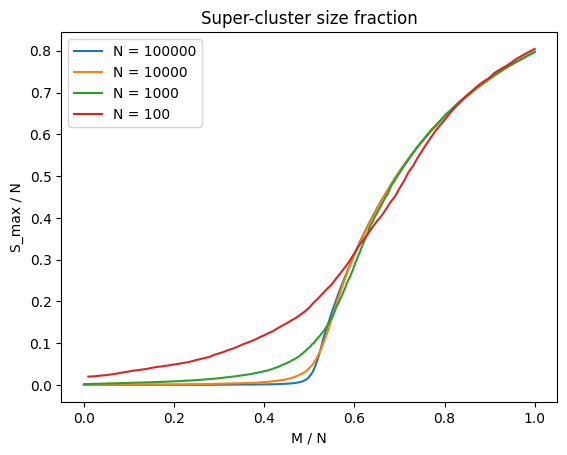

In [7]:
for size in reversed(graph_sizes):
    plt.plot(sol_dict[size]['c'], sol_dict[size]['Smax_mean'],label="N = "+str(size));
    
plt.legend()
plt.xlabel("M / N")
plt.ylabel("S_max / N")
plt.title("Super-cluster size fraction")

plt.show()